Using the other object as test set 🤪

/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_58282/3506164697.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x,sigmoid(x),'r', c='tab:blue')


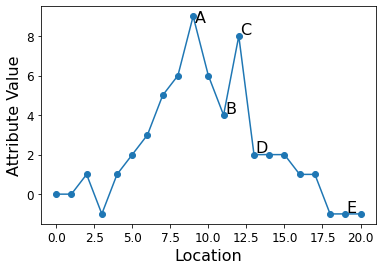

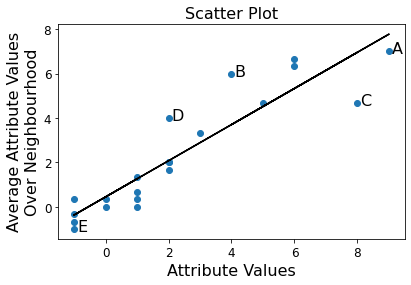

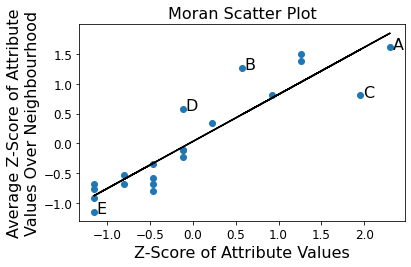

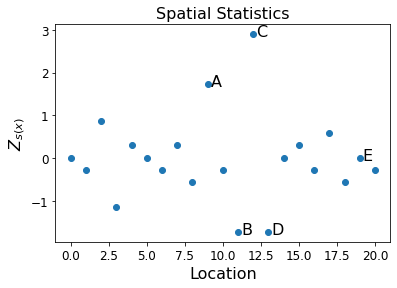

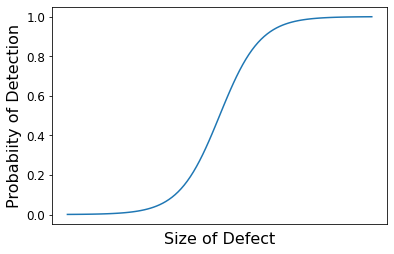

<Figure size 432x288 with 0 Axes>

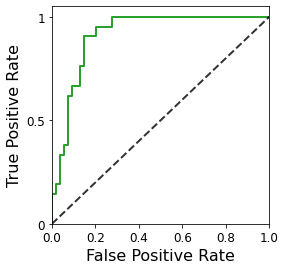

In [12]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Två delar:
# 1: fixa segmentstorleken
# 2: fixa masker för varje segment
# Eller egentligen, skit i det. Applicera masken i förväg?

spatialdata = np.array([0, 0, 1, -1, 1, 2, 3, 5, 6, 9, 6, 4, 8, 2, 2, 2, 1, 1, -1, -1, -1])

xs = np.arange(0, len(spatialdata))

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

plt.plot(xs, spatialdata, 'o-')
plt.text(9.1,8.7,'A')
plt.text(11.1,4.1,'B')
plt.text(12.1,8.1,'C')
plt.text(13.1,2.1,'D')
plt.text(19.1,-0.9,'E')
# plt.plot(xs, np.convolve(spatialdata, [1,1,1], 'same')/3)
plt.xlabel("Location")
plt.ylabel("Attribute Value")
plt.savefig("figures/original.png", dpi=300)

plt.figure()
neighbourhoodValues = np.convolve(spatialdata, np.array([1,1,1])/3, 'same')
plt.scatter(spatialdata, neighbourhoodValues)
plt.xlabel("Attribute Values")
plt.ylabel("Average Attribute Values\nOver Neighbourhood")
plt.text(spatialdata[9]+0.1,neighbourhoodValues[9]-0.1,'A')
plt.text(spatialdata[11]+0.1,neighbourhoodValues[11]-0.1,'B')
plt.text(spatialdata[12]+0.1,neighbourhoodValues[12]-0.1,'C')
plt.text(spatialdata[13]+0.1,neighbourhoodValues[13]-0.1,'D')
plt.text(spatialdata[19]+0.1,neighbourhoodValues[19]-0.1,'E')
line = np.polyfit(spatialdata.flatten(), neighbourhoodValues.flatten(), 1)
p = np.poly1d(line)
# plt.Line2D(spatialdata.flatten(), p(spatialdata.flatten()))
plt.plot(spatialdata.flatten(), p(spatialdata.flatten()), color="black", lw=1.5)
plt.tight_layout()
plt.title("Scatter Plot")
plt.savefig("figures/scatter.png", dpi=300)
# Fit line

plt.figure()
normalised = (spatialdata - np.average(spatialdata)) / np.std(spatialdata)
neighbourhoodValues2 = np.convolve(normalised, np.array([1,1,1])/3, 'same')
plt.scatter(normalised, neighbourhoodValues2)
plt.xlabel("Z-Score of Attribute Values")
plt.ylabel("Average Z-Score of Attribute\nValues Over Neighbourhood")
plt.text(normalised[9]+0.03,neighbourhoodValues2[9]-0.025,'A')
plt.text(normalised[11]+0.03,neighbourhoodValues2[11]-0.025,'B')
plt.text(normalised[12]+0.03,neighbourhoodValues2[12]-0.025,'C')
plt.text(normalised[13]+0.03,neighbourhoodValues2[13]-0.025,'D')
plt.text(normalised[19]+0.03,neighbourhoodValues2[19]-0.025,'E')
line = np.polyfit(normalised.flatten(), neighbourhoodValues2.flatten(), 1)
p = np.poly1d(line)
plt.plot(normalised.flatten(), p(normalised.flatten()), color="black", lw=1.5)
plt.title("Moran Scatter Plot")
plt.tight_layout()
plt.savefig("figures/moran.png", dpi=300)
# Fit line

plt.figure()
diff = spatialdata - neighbourhoodValues
spatialStatistic = (diff - np.average(diff)) / np.std(diff)
plt.scatter(xs, spatialStatistic)
plt.xlabel("Location")
plt.ylabel("$Z_{s(x)}$")
plt.text(xs[9]+0.2,spatialStatistic[9]-0.05,'A')
plt.text(xs[11]+0.2,spatialStatistic[11]-0.05,'B')
plt.text(xs[12]+0.2,spatialStatistic[12]-0.05,'C')
plt.text(xs[13]+0.2,spatialStatistic[13]-0.05,'D')
plt.text(xs[19]+0.2,spatialStatistic[19]-0.05,'E')
plt.title("Spatial Statistics")
plt.savefig("figures/spatialstatistics.png", dpi=300)
# Fit line


plt.figure()

sigmoid = lambda x: 1 / (1 + np.exp((2.5-x)*3))
x=np.linspace(0,5,100)
plt.plot(x,sigmoid(x),'r', c='tab:blue')
plt.ylabel("Probabiity of Detection")
plt.xlabel("Size of Defect")
plt.xticks([])

plt.savefig("figures/pod-example.png", dpi=300)

plt.figure()

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.axes().set_box_aspect(1)
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="tab:green",
    lw=lw,
    label="ROC curve",
)
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--", alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.savefig("figures/roc-example.png", dpi=300)
plt.show()